In [48]:
import os
directory = os.path.dirname(os.getcwd())
import sys
sys.path.append(directory)
import lxml
import datetime
import hashlib
import pandas as pd
import statistics
import numpy as np
from typing import Dict, List
from collections import defaultdict
from ipywidgets import interact, widgets
from IPython import display as ICD


import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.util import ngrams
from nltk.stem import PorterStemmer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import string

import matplotlib.pyplot as plt
%matplotlib inline

import src.data as data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Variables

In [2]:
DIRECTORY_DATA = os.path.join(directory, 'data')
DIRECTORY_OUTPUT = os.path.join(DIRECTORY_DATA,'01')

# Parsing Dataset

In [3]:
dblp = data.DatasetDBLP(directory_output=DIRECTORY_OUTPUT)
filepath = os.path.join(DIRECTORY_DATA, 'dblp.xml')
dblp.from_file(filepath)

In [4]:
inproceedings = defaultdict(lambda: defaultdict(list))

In [5]:
all_elements = ['inproceedings']
for event, element in dblp.data:
    if element.tag in all_elements:
        conference_name = element.items()[1][1].split('/')[1]
        for sub in element:
            if sub.tag == 'title':
                t = sub.text
            if sub.tag == 'year':
                d = sub.text
        inproceedings[conference_name][d].append(t)

# Inproceedings Count By Year

In [14]:
def plot_inproceedings_count_by_year(conference_name: str):
    tmp = []
    for k, v in inproceedings[conference_name].items():

        tmp.append([k, len(v)])
    print(tmp)
    df = pd.DataFrame(tmp, columns=['year', 'count'])
    df.sort_values('year', inplace=True)
    fig = df.plot.bar('year', 'count').get_figure()
    fig.savefig(os.path.join(DIRECTORY_OUTPUT, conference_name+'_count.png'))
    

interact(plot_inproceedings_count_by_year, conference_name=sorted([conf for conf in list(inproceedings.keys()) if conf]))

interactive(children=(Dropdown(description='conference_name', options=('3dgis', '3dic', '3dica', '3dim', '3dor…

<function __main__.plot_inproceedings_count_by_year(conference_name: str)>

# Title Length by Year

In [15]:
def plot_title_length_by_year(conference_name: str):
    tmp = []
    y = []
    for k, v in inproceedings[conference_name].items():
        lengths = []
        for t in v:
            if not t is None:
                lengths.append(len(t.split(' ')))

        tmp.append( {'label': k,'whislo':min(lengths), 'whishi':max(lengths), 'med':statistics.median(lengths), 'q1':np.percentile(lengths, 25), 'q3':np.percentile(lengths, 75)})
        y.append(k)
    tmp = sorted(tmp, key=lambda x: x['label'])
    y = sorted(y)

    fig, ax = plt.subplots(1,1)
    ax.bxp(tmp, showfliers=False)
    ax.set_xticks(ticks=range(1, len(y)+1),labels=y, rotation=90)
    fig.savefig(os.path.join(DIRECTORY_OUTPUT, conference_name+'_title_length.png'))

interact(plot_title_length_by_year, conference_name=sorted([conf for conf in list(inproceedings.keys()) if conf]))    

interactive(children=(Dropdown(description='conference_name', options=('3dgis', '3dic', '3dica', '3dim', '3dor…

<function __main__.plot_title_length_by_year(conference_name: str)>

# Top 10s

In [50]:
TOPN = 5

ngrams_radio = widgets.ToggleButtons(
    options=['unigram', 'bigram', 'trigram', 'combined'],
    description='ngram:',
    disabled=False,
    tooltips=['top unigrams', 'top bigrams', 'top trigrams', 'top combined'],
)

stem_radio = widgets.ToggleButtons(
    options=['none', 'porter'],
    description='stemmer:',
    disabled=False,
    tooltips=['no stemming', 'stemming using porter stemmer'],
)

nounonly_checkbox = widgets.ToggleButtons(
    options=['all', 'nouns_only'],
    description='tokens:',
    disabled=False,
    tooltips=['use all available tokens', 'use nouns only'],
)

In [23]:
def generate_top_10_unigrams(ngram: str, nounonly: str, stemmer: str, conference_name: str):
    years = sorted([int(y) for y in list(inproceedings[conference_name].keys()) if y])
    if ngram == 'unigram':
        n = 1
    elif ngram == 'bigram':
        n = 2
    elif ngram == 'trigram':
        n = 3
    elif ngram == 'combined':
        n = 3
        
    def get_titles(year: int):
        if ngram == 'combined':
            outputs = [defaultdict(lambda:defaultdict(int)) for i in range(n)]
        else:
            outputs = [defaultdict(lambda:defaultdict(int))]
        sw = set(stopwords.words("english") + list(string.punctuation))
        ps = PorterStemmer()
        counts = defaultdict(lambda:defaultdict(int))
        titles = inproceedings[conference_name][str(year)]
        for t in titles:
            if t:
                tokens = word_tokenize(t)
                if nounonly == 'nouns_only':
                    tokens = nltk.tag.pos_tag(tokens)
                    tokens = [word[0] for word in tokens if (word[1]=='NN')]    
                tokens = [word for word in tokens if (not word.lower() in sw)]
                if ngram == 'combined':
                    for i in range(n):
                        ngs = ngrams(tokens,i+1)
                        for gram in ngs:
                            if stemmer != 'none':
                                phrase = ps.stem(TreebankWordDetokenizer().detokenize(gram))
                            else:
                                phrase = TreebankWordDetokenizer().detokenize(gram)
                            outputs[i][year][phrase] += 1   
                else:
                    ngs = ngrams(tokens,n)
                    for gram in ngs:
                        if stemmer != 'none':
                            phrase = ps.stem(TreebankWordDetokenizer().detokenize(gram))
                        else:
                            phrase = TreebankWordDetokenizer().detokenize(gram)
                        outputs[0][year][phrase] += 1      
        topten = dict()
        for output in reversed(outputs): 
            for k, v in output.items():
                _ = [[k,v] for k,v in v.items()]
                _ = sorted(_,key=lambda x: x[1],reverse=True)
                
                if ngram == 'combined':
                    top = [t for t in _ if t[1] > 1]
                else:
                    top = _
                if k in topten:
                    topten[k] += top
                else:
                    topten[k] = top
            if len(topten[k])>TOPN:
                topten[k] = topten[k][:TOPN]
                break
                
        return topten
    
    interact(get_titles, year=years)    
    
interact(generate_top_10_unigrams, 
    ngram = ngrams_radio,
    nounonly = nounonly_checkbox,
    stemmer = stem_radio,
    conference_name=sorted([conf for conf in list(inproceedings.keys()) if conf]),
    
) 

interactive(children=(ToggleButtons(description='ngram:', index=1, options=('unigram', 'bigram', 'trigram', 'c…

<function __main__.generate_top_10_unigrams(ngram: str, nounonly: str, stemmer: str, conference_name: str)>

In [67]:
ranking = None
totalyears = None
def generate_top_10_unigrams_new(ngram: str, nounonly: str, stemmer: str, conference_name: str):
    years = sorted([int(y) for y in list(inproceedings[conference_name].keys()) if y])
    global totalyears
    totalyears = years
    if ngram == 'unigram':
        n = 1
    elif ngram == 'bigram':
        n = 2
    elif ngram == 'trigram':
        n = 3
    elif ngram == 'combined':
        n = 3
        
    def get_titles(year: int):
        if ngram == 'combined':
            outputs = [defaultdict(lambda:defaultdict(int)) for i in range(n)]
        else:
            outputs = [defaultdict(lambda:defaultdict(int))]
        sw = set(stopwords.words("english") + list(string.punctuation))
        ps = PorterStemmer()
        # counts = defaultdict(lambda:defaultdict(int))
        for yr in years:
            titles = inproceedings[conference_name][str(yr)]
            for t in titles:
                if t:
                    tokens = word_tokenize(t)
                    if nounonly == 'nouns_only':
                        tokens = nltk.tag.pos_tag(tokens)
                        tokens = [word[0] for word in tokens if (word[1]=='NN')]    
                    tokens = [word for word in tokens if (not word.lower() in sw)]
                    if ngram == 'combined':
                        for i in range(n):
                            ngs = ngrams(tokens,i+1)
                            for gram in ngs:
                                if stemmer != 'none':
                                    phrase = ps.stem(TreebankWordDetokenizer().detokenize(gram))
                                else:
                                    phrase = TreebankWordDetokenizer().detokenize(gram)
                                outputs[i][str(yr)][phrase] += 1   
                    else:
                        ngs = ngrams(tokens,n)
                        for gram in ngs:
                            if stemmer != 'none':
                                phrase = ps.stem(TreebankWordDetokenizer().detokenize(gram))
                            else:
                                phrase = TreebankWordDetokenizer().detokenize(gram)
                            outputs[0][str(yr)][phrase] += 1      
        topten = dict()
        for output in reversed(outputs): 
            for k, v in output.items():
                _ = [[k,v] for k,v in v.items()]
                _ = sorted(_,key=lambda x: x[1],reverse=True)
                
                if ngram == 'combined':
                    top = [t for t in _ if t[1] > 1]
                else:
                    top = _
                if k in topten:
                    topten[k] += top
                else:
                    topten[k] = top
        trend = []
        for k, v in topten.items():
            if len(v)>TOPN:
                topten[k] = v[:TOPN]
            _ = [phrase[0] for phrase in topten[k]]
            _ = [str(k)] + _
            trend.append(_)
        global ranking 
        ranking = topten
        currenttrend = pd.DataFrame(topten[str(year)], columns=['word', 'count'])
        ICD.display(currenttrend)
        
        trend = pd.DataFrame(trend, columns=['year'] + list(range(1,TOPN+1)))
        
                
        return trend
    
    interact(get_titles, year=years)    
    
interact(generate_top_10_unigrams_new, 
    ngram = ngrams_radio,
    nounonly = nounonly_checkbox,
    stemmer = stem_radio,
    conference_name=sorted([conf for conf in list(inproceedings.keys()) if conf]),
    
) 

interactive(children=(ToggleButtons(description='ngram:', index=3, options=('unigram', 'bigram', 'trigram', 'c…

<function __main__.generate_top_10_unigrams_new(ngram: str, nounonly: str, stemmer: str, conference_name: str)>

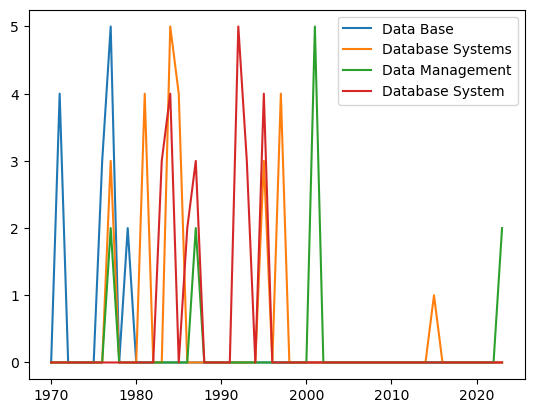

In [107]:
bywords = dict()
bywordscount = defaultdict(int)

for k, v in ranking.items():
    for word in v:
        bywords[word[0]] = [0] * len(totalyears)

counter = 0
for k, v in ranking.items():
    rank = len(v)
    for i in range(len(v)):
        
        bywords[v[i][0]][counter] = (rank-i)
        bywordscount[v[i][0]] += 1
    counter += 1
    
relevantwords = [k for k,v in bywordscount.items() if v > 3]
results = {word:bywords[word] for word in relevantwords}
results = pd.DataFrame(results, index=totalyears)
p = results.plot()
fig = p.get_figure()
fig.savefig('trend.png')
